<a href="https://colab.research.google.com/github/tburger101/Late-Swap/blob/main/late_swap_eff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

## **Loading and transforming data**

In [2]:
'''Load the data'''

pd.set_option('display.max_rows', 500)
df=pd.read_csv("/content/late_swap_20_22.csv")

In [3]:
'''Create predicted rank bins so it is easier to analyze by segment'''

df['cash']=0
df.loc[df['actual_perc'] <.2, 'cash'] =1
df['eff_rank_bin']=pd.cut(df['eff_rank'], [(x)/100 for x in range (0,101)])
df['eff_rank_bin_5']=pd.cut(df['eff_rank'], [(x*5)/100 for x in range (0,21)])
df['final_rank_bin']=pd.cut(df['actual_perc'], [(x)/100 for x in range (0,101)])
df['act_minus_eff']=df['actual_perc']-df['eff_rank']

## **Data Exploration Top 10**

In [4]:
'''Breakdown of how likely you are to finish in the top 10 based on your early efficiency rank'''

(pd.pivot_table(df[(df['eff_rank']<.15) & (df['remaining_players']>0)], values='top_10', index=['eff_rank_bin'],
                    aggfunc=np.average))
# plt.title('Top 10 Perc Chance and Eff Rank')
# plt.ylabel('Perc Chance Top 10')
# plt.xlabel('Eff Rank') 

,top_10
eff_rank_bin,
"(0.0, 0.01]",0.078351
"(0.01, 0.02]",0.033996
"(0.02, 0.03]",0.018344
"(0.03, 0.04]",0.012176
"(0.04, 0.05]",0.004685
"(0.05, 0.06]",0.004834
"(0.06, 0.07]",0.004260
"(0.07, 0.08]",0.002662
"(0.08, 0.09]",0.002697


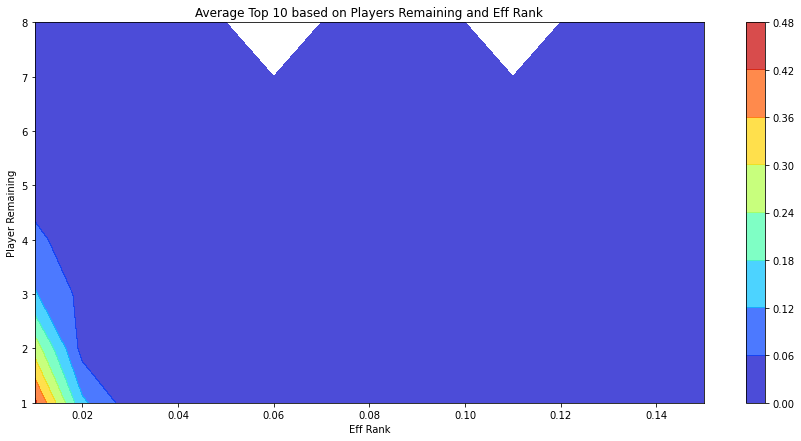

In [11]:
'''Breakdown of how likely you are to finish in the top 10 based on your early efficiency rank
and the number of players remaining'''

pd.set_option('display.max_rows', 500)
contour_data=pd.pivot_table(df[(df['eff_rank']<.15) & (df['remaining_players']>0)], values='top_10', index=['eff_rank_bin'],
                    columns=['remaining_players'], aggfunc=np.average)

# fig = plt.figure(figsize=(6,5))
# left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
# ax = fig.add_axes([left, bottom, width, height]) 

X=[contour_data.columns.values]
Y=[x/100 for x in range(1,16)]
Z=contour_data.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(15,7))
a=plt.contourf(Yi, Xi, Z, alpha=0.7, cmap=plt.cm.jet)

plt.title('Average Top 10 based on Players Remaining and Eff Rank')
plt.xlabel('Eff Rank')
plt.ylabel('Player Remaining') 
plt.colorbar(a)

In [6]:
'''Breakdown of how likely you are to cash based on your early efficiency rank'''

pd.pivot_table(df[(df['remaining_players']>0)], values='cash', index=['eff_rank_bin_5'],
                    aggfunc=np.average)

,cash
eff_rank_bin_5,
"(0.0, 0.05]",0.775758
"(0.05, 0.1]",0.711113
"(0.1, 0.15]",0.580180
"(0.15, 0.2]",0.462504
"(0.2, 0.25]",0.336337
"(0.25, 0.3]",0.247802
"(0.3, 0.35]",0.186822
"(0.35, 0.4]",0.129429
"(0.4, 0.45]",0.100486


Text(0.5, 0, 'Eff Rank')

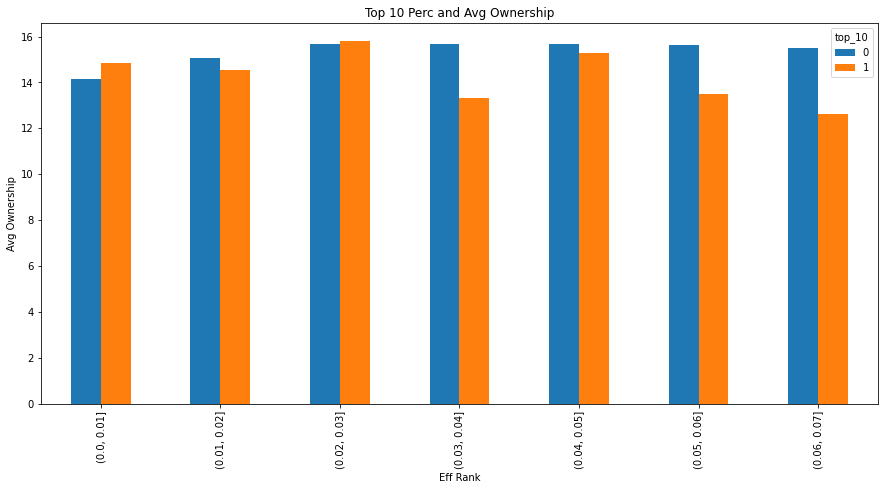

In [8]:
'''How do you need to play to move up to a top 10 spot based on your efficiency rank'''

top_5=df[(df['eff_rank']<=.07) &  (df['remaining_players']>0)]
pd.pivot_table(top_5, values='avg_ownership', index=['eff_rank_bin'],
                    columns=['top_10'], aggfunc=np.average).plot.bar(figsize=(15,7))

plt.title('Top 10 Perc and Avg Ownership')
plt.ylabel('Avg Ownership')
plt.xlabel('Eff Rank') 

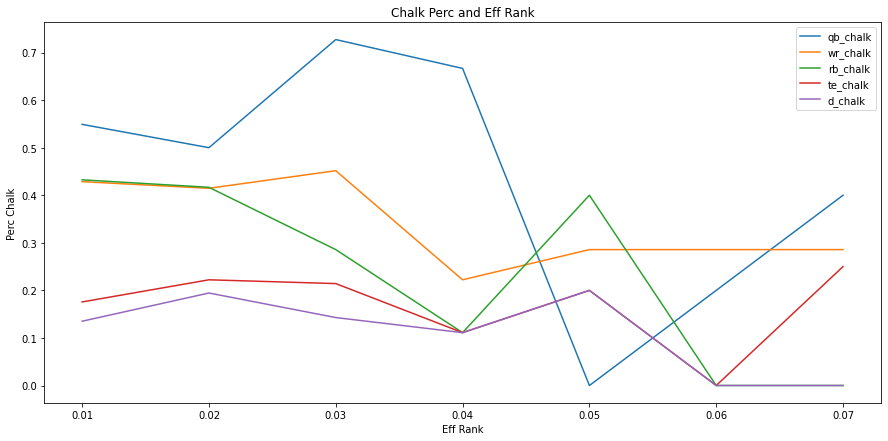

In [13]:
'''How often was the chalk played in the afternoon games of the Top 10 Finishers and where they stood after the morning slate of games'''

import matplotlib.pyplot as plt
''' To get in the top .1% as your team starts slower you have to get different in order to get there'''
qb_chalk=df[(df['top_10']==1)& (df['qb_remaining']==1)& (df['eff_rank']<.07)].groupby('eff_rank_bin')['chalk_qb'].mean()
wr_chalk=df[(df['top_10']==1)& (df['wr_remaining']>=1)& (df['eff_rank']<.07) ].groupby('eff_rank_bin')['chalk_wr'].mean()
rb_chalk=df[(df['top_10']==1)& (df['rb_remaining']>=1)& (df['eff_rank']<.07)].groupby('eff_rank_bin')['chalk_rb'].mean()
te_chalk=df[(df['top_10']==1)& (df['rb_remaining']>=1)& (df['eff_rank']<.07)].groupby('eff_rank_bin')['chalk_te'].mean()
d_chalk=df[(df['top_10']==1)& (df['rb_remaining']>=1)& (df['eff_rank']<.07)].groupby('eff_rank_bin')['chalk_d'].mean()

plt.figure(figsize=(15,7))
plt.plot([x/100 for x in range(1,101)],qb_chalk.values,  label = "qb_chalk")
plt.plot([x/100 for x in range(1,101)],wr_chalk.values,  label = "wr_chalk")
plt.plot([x/100 for x in range(1,101)],rb_chalk.values, label = "rb_chalk")
plt.plot([x/100 for x in range(1,101)],te_chalk.values, label = "te_chalk")
plt.plot([x/100 for x in range(1,101)],d_chalk.values, label = "d_chalk")

plt.ylabel('Perc Chalk')
plt.xlabel('Eff Rank')
plt.title('Chalk Perc and Eff Rank')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

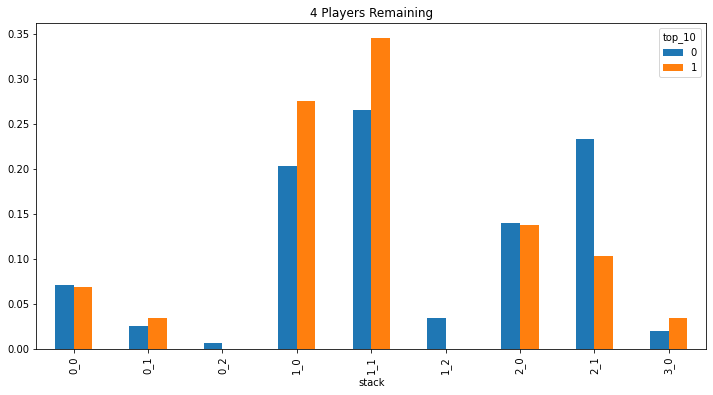

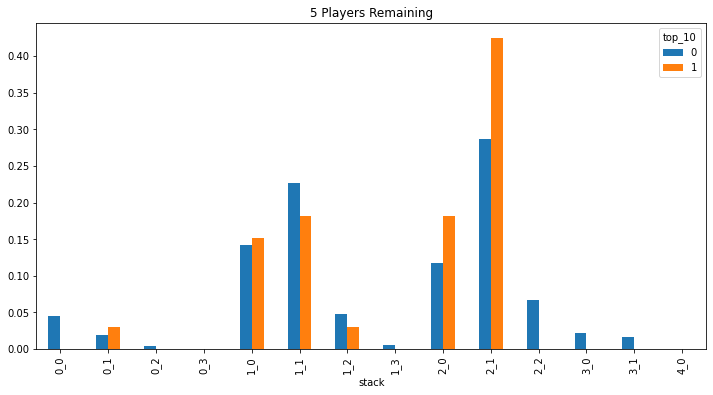

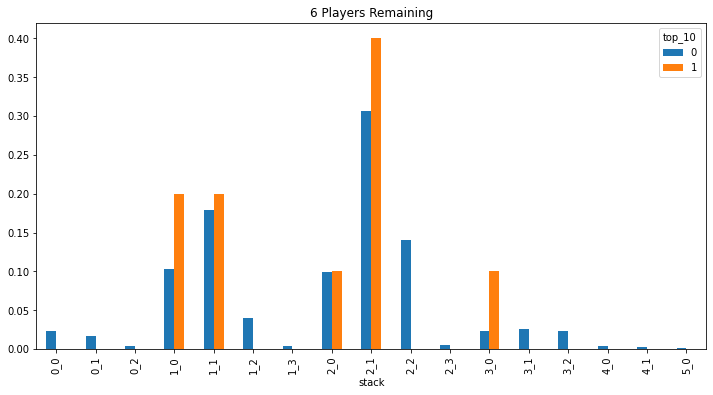

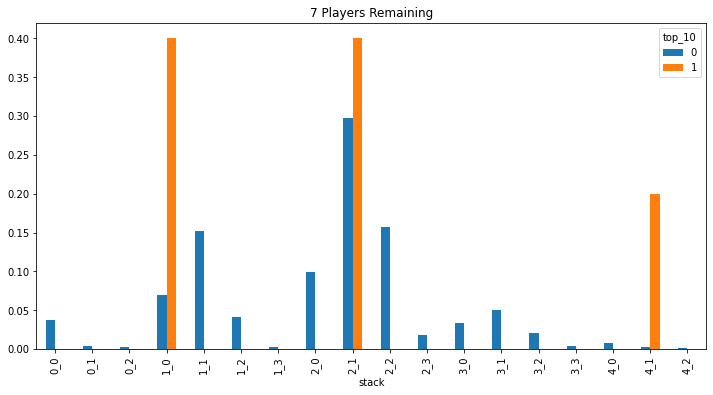

In [10]:
'''Optimal stack construction for top top 5 predicted percent with less than 4 players'''

for x in [4,5,6,7]:
  qb_df=df[(df['eff_rank']<=.07) & (df['qb_remaining']==1) & (df['remaining_players']==x)]
  pd.crosstab(columns=qb_df['top_10'], index=qb_df['stack'],
              values='entry_id', aggfunc='count', normalize='columns').plot.bar(figsize=(12, 6))
  plt.title(str(x)+" Players Remaining")

# **Data Exploration Cashing**


In [16]:
'''Breakdown of how likely you are to cash based on your early efficiency rank'''

pd.pivot_table(df[(df['remaining_players']>0)], values='cash', index=['eff_rank_bin_5'],
                    aggfunc=np.average)

,cash
eff_rank_bin_5,
"(0.0, 0.05]",0.775758
"(0.05, 0.1]",0.711113
"(0.1, 0.15]",0.580180
"(0.15, 0.2]",0.462504
"(0.2, 0.25]",0.336337
"(0.25, 0.3]",0.247802
"(0.3, 0.35]",0.186822
"(0.35, 0.4]",0.129429
"(0.4, 0.45]",0.100486


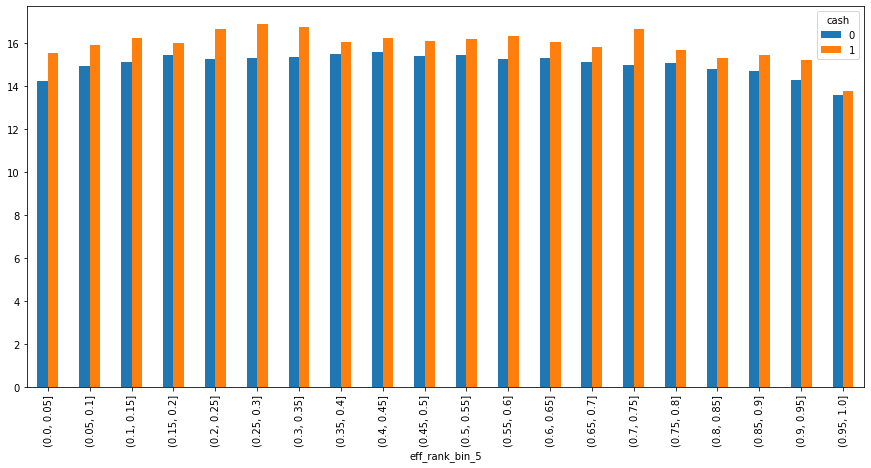

In [17]:
'''How do you need to play to move up to a cashing spot based on your efficiency rank'''

top_5=df[(df['remaining_players']>0)]
pd.pivot_table(top_5, values='avg_ownership', index=['eff_rank_bin_5'],
                    columns=['cash'], aggfunc=np.average).plot.bar(figsize=(15,7))

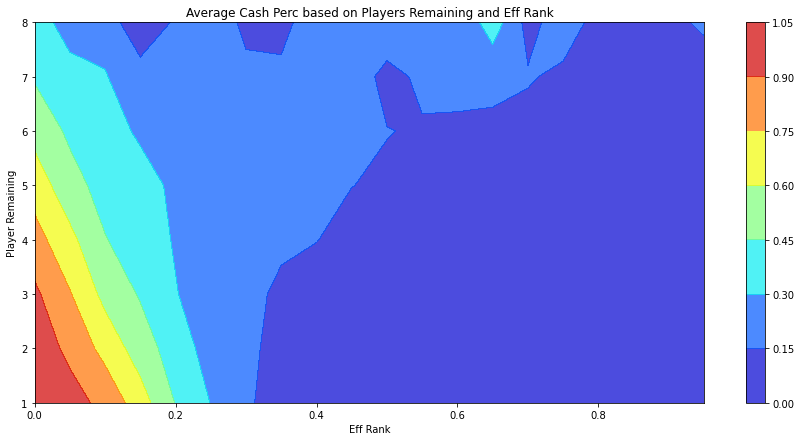

In [14]:
'''Breakdown of how likely you are to cash based on your early efficiency rank
and the number of players remaining'''

pd.set_option('display.max_rows', 500)
contour_data=pd.pivot_table(df[(df['remaining_players']>0)], values='cash', index=['eff_rank_bin_5'],
                    columns=['remaining_players'], aggfunc=np.average)

# fig = plt.figure(figsize=(6,5))
# left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
# ax = fig.add_axes([left, bottom, width, height]) 

X=[contour_data.columns.values]
Y=[(x*5)/100 for x in range (0,20)]
Z=contour_data.values
Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(15,7))
a=plt.contourf(Yi, Xi, Z, alpha=0.7, cmap=plt.cm.jet)

plt.title('Average Cash Perc based on Players Remaining and Eff Rank')
plt.xlabel('Eff Rank')
plt.ylabel('Player Remaining') 
plt.colorbar(a)